# Etiquetado de T√≥picos Predefinidos con LLM Multi-Etiqueta

Este notebook implementa un sistema de clasificaci√≥n multi-etiqueta para rese√±as tur√≠sticas utilizando un LLM con salida estructurada. El objetivo es etiquetar cada rese√±a con categor√≠as predefinidas para posteriormente entrenar modelos BERT o similares.

## Import Required Libraries

In [1]:
import pandas as pd
from typing import List
from pydantic import BaseModel, Field, validator
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
import time
import os

## Setup LLM and Pydantic Models

In [2]:
# Configuraci√≥n de modelos LLM - Ejecutar m√∫ltiples modelos
MODELS_TO_USE = ["gpt-4.1-mini", "gpt-4o-mini"]  # Lista de modelos a procesar
MODEL_NAME = MODELS_TO_USE[0]  # Modelo actual en procesamiento
COLUMN_NAME = f"TopicoConLLM_{MODEL_NAME}"

class MultiLabelOutput(BaseModel):
    labels: List[int] = Field(..., description="Lista de n√∫meros de categor√≠as aplicables (0-13)")
    
    @validator('labels')
    def validate_labels(cls, v):
        valid_labels = set(range(14))  # Ahora 0-13
        
        if not all(label in valid_labels for label in v):
            raise ValueError("Todas las etiquetas deben estar entre 0 y 13")
        
        # Manejo autom√°tico de la categor√≠a 13 (Otros) cuando aparece con otras etiquetas
        if 13 in v and len(v) > 1:
            # Si la categor√≠a 13 aparece con otras, la removemos autom√°ticamente
            # ya que las otras categor√≠as son m√°s espec√≠ficas
            v_filtered = [label for label in v if label != 13]
            print(f"‚ö†Ô∏è Categor√≠a 13 removida autom√°ticamente. Etiquetas finales: {v_filtered}")
            return sorted(list(set(v_filtered)))
        
        return sorted(list(set(v)))

llm = ChatOpenAI(
    model=MODEL_NAME,
    temperature=0
)

parser = PydanticOutputParser(pydantic_object=MultiLabelOutput)

/tmp/ipykernel_137188/2560088584.py:9: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('labels')


## Load and Prepare Dataset

In [3]:
df = pd.read_csv('../data/processed/dataset_opiniones_analisis.csv')

print(f"Dataset cargado: {len(df)} rese√±as")
print(f"Primeras columnas: {list(df.columns[:5])}")
print(f"Ejemplo de TituloReview: {df['TituloReview'].iloc[0][:100]}...")

Dataset cargado: 2457 rese√±as
Primeras columnas: ['Titulo', 'Review', 'Calificacion', 'FechaEstadia', 'Ciudad']
Ejemplo de TituloReview: ¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, Mx. . La gente aqu√≠ es amable. . nos aloj...


## Limpieza de columnas obsoletas

In [ ]:
# Eliminar la columna TopicoConLLM gen√©rica si existe para evitar confusiones
# Solo debemos mantener las columnas espec√≠ficas por modelo (TopicoConLLM_gpt-4.1-mini, etc.)
if 'TopicoConLLM' in df.columns:
    print(f"Eliminando columna obsoleta 'TopicoConLLM'...")
    df = df.drop('TopicoConLLM', axis=1)
    print("‚úì Columna 'TopicoConLLM' eliminada")
else:
    print("‚úì No existe la columna 'TopicoConLLM' - sin cambios necesarios")

# Verificar qu√© columnas de t√≥picos existen actualmente
llm_columns = [col for col in df.columns if col.startswith('TopicoConLLM')]
print(f"\nColumnas de t√≥picos LLM encontradas: {llm_columns}")
print(f"Forma del dataset: {df.shape}")

## Create Classification Prompt

In [4]:
prompt_template = """
Eres un experto en turismo. Clasifica esta rese√±a tur√≠stica en las categor√≠as que correspondan. Puedes asignar m√∫ltiples categor√≠as a una sola rese√±a.

CATEGOR√çAS (0-12):
0. Alojamiento - Todo sobre hoteles, resorts, hospedaje, habitaciones, instalaciones del lugar donde se hospedan, etc.
1. Gastronom√≠a - Comida, restaurantes, bebidas, experiencias culinarias, sabores locales, etc.
2. Transporte - Cualquier medio de transporte: taxis, autobuses, pulmon√≠as, vuelos, traslados, accesibilidad, etc.
3. Eventos y festivales - Carnaval, festivales, eventos especiales, espect√°culos, celebraciones, etc.
4. Historia y cultura - Sitios hist√≥ricos, museos, cultura local, tradiciones, patrimonio, arquitectura, etc.
5. Compras - Tiendas, mercados, artesan√≠as, souvenirs, precios, vendedores, costos de productos, etc.
6. Deportes y aventura - Actividades f√≠sicas, deportes, aventuras, clavadistas, actividades extremas, etc.
7. Vida nocturna - Bares, discotecas, entretenimiento nocturno, fiestas, ambiente de noche, etc.
8. Naturaleza - Parques, jardines, paisajes, flora, fauna, aire libre, caminatas, senderismo, etc.
9. Playas y mar - Playas, oc√©ano, actividades acu√°ticas, nataci√≥n, deportes de agua, costa, etc.
10. Personal y servicio - Atenci√≥n al cliente, amabilidad, servicio, trato del personal en cualquier lugar, etc.
11. Seguridad - Temas de seguridad, delincuencia, robos, protecci√≥n, precauciones, etc.
12. Fauna y vida animal - Zool√≥gicos, acuarios, observaci√≥n de animales terrestres/marinos, safaris, espect√°culos con animales, etc.

CATEGOR√çA ESPECIAL:
13. Otros - SOLO cuando la rese√±a no encaje en NINGUNA categor√≠a anterior

INSTRUCCIONES SIMPLES:
- Lee la rese√±a completa
- Identifica qu√© categor√≠as (0-12) mencionan o describen
- Si algo encaja en alguna categor√≠a (0-12), √∫sala
- Solo usa [13] si absolutamente nada encaja en las categor√≠as 0-12
- Devuelve los n√∫meros como lista: [0], [1,5], [2,10,11], etc.

RESE√ëA:
{review_text}

{format_instructions}
"""

prompt = PromptTemplate(
    template=prompt_template,
    input_variables=["review_text"],
    partial_variables={"format_instructions": parser.get_format_instructions()}
)

# IMPORTANTE: Crear el chain aqu√≠
chain = prompt | llm | parser

## Implement Batch Processing Function

In [5]:
def classify_review(review_text, max_retries=2):
    """
    Clasifica una rese√±a con reintentos autom√°ticos en caso de error.
    """
    for attempt in range(max_retries + 1):
        try:
            result = chain.invoke({"review_text": review_text})
            return result.labels
        except Exception as e:
            error_msg = str(e)
            if attempt < max_retries:
                print(f"‚ö†Ô∏è Intento {attempt + 1} fall√≥, reintentando... Error: {error_msg[:80]}...")
                time.sleep(1)  # Pausa antes del reintento
            else:
                print(f"‚ùå Error final procesando rese√±a despu√©s de {max_retries + 1} intentos: {error_msg[:100]}...")
                # En caso de error persistente, asignamos categor√≠a "Otros"
                return [13]  # Cambiado de 12 a 13

def process_reviews_batch(df, start_idx=0, batch_size=50):
    results = []
    total = len(df)
    error_count = 0
    
    for i in range(start_idx, total):
        if i % batch_size == 0:
            print(f"Procesando {i}/{total} rese√±as... (Errores hasta ahora: {error_count})")
        
        review = df.iloc[i]['TituloReview']
        labels = classify_review(review)
        
        # Contar si hubo alg√∫n error (etiqueta 13 sola puede indicar error)
        if labels == [13]:  # Cambiado de 12 a 13
            error_count += 1
            
        results.append(labels)
        time.sleep(0.5)
    
    print(f"‚úÖ Procesamiento completado. Total errores/casos 'Otros': {error_count}/{total}")
    return results

## Process Dataset Reviews

In [ ]:
ETIQUETAR_DE_NUEVO = False  # Cambia a True para reetiquetar todo el dataset

# Procesar m√∫ltiples modelos
for model_idx, model in enumerate(MODELS_TO_USE):
    MODEL_NAME = model
    COLUMN_NAME = f"TopicoConLLM_{MODEL_NAME}"
    
    print(f"\n{'='*80}")
    print(f"ü§ñ PROCESANDO MODELO {model_idx + 1}/{len(MODELS_TO_USE)}: {MODEL_NAME}")
    print(f"{'='*80}")
    
    # Actualizar el LLM con el modelo actual
    llm = ChatOpenAI(
        model=MODEL_NAME,
        temperature=0
    )
    
    # Actualizar el chain con el nuevo LLM
    chain = prompt | llm | parser
    
    if COLUMN_NAME not in df.columns or ETIQUETAR_DE_NUEVO:    
        print(f"Clasificando con modelo: {MODEL_NAME}")
        print("Clasificando primeras 5 rese√±as como prueba...")
        test_labels = []
        for i in range(5):
            review = df.iloc[i]['TituloReview']
            labels = classify_review(review)
            test_labels.append(labels)
            print(f"Rese√±a {i+1}: {review[:50]}... -> {labels}")
            time.sleep(1)

        print(f"\nüöÄ Procesando todo el dataset con {MODEL_NAME}...")
        all_labels = process_reviews_batch(df)
        
        # Asignar las etiquetas a la columna correspondiente
        df[COLUMN_NAME] = all_labels
        
        print(f"‚úÖ Completado modelo {MODEL_NAME}")
        
        # Guardar progreso despu√©s de cada modelo
        output_path = '../data/processed/dataset_opiniones_analisis.csv'
        # Solo guardar columnas necesarias (mantener originales + columnas LLM)
        columns_to_save = [col for col in df.columns if not col.startswith('TopicoConLLM') or col.startswith('TopicoConLLM_')]
        df_to_save = df[columns_to_save].copy()
        df_to_save.to_csv(output_path, index=False)
        print(f"üíæ Dataset guardado con progreso de {model}")
    else:
        print(f"‚ö†Ô∏è Modelo {MODEL_NAME} ya procesado, saltando...")

print(f"\nüéâ TODOS LOS MODELOS COMPLETADOS: {MODELS_TO_USE}")


ü§ñ PROCESANDO MODELO 1/2: gpt-4.1-mini
Clasificando con modelo: gpt-4.1-mini
Clasificando primeras 5 rese√±as como prueba...
Rese√±a 1: ¬°Divertido y seguro!. Estoy muy impresionado con M... -> [0, 1, 10, 11]
Rese√±a 1: ¬°Divertido y seguro!. Estoy muy impresionado con M... -> [0, 1, 10, 11]
Rese√±a 2: Un mes en Mazatl√°n. Acabamos de pasar un mes en Ma... -> [3, 9, 10, 11]
Rese√±a 2: Un mes en Mazatl√°n. Acabamos de pasar un mes en Ma... -> [3, 9, 10, 11]
Rese√±a 3: Maravilloso. Ubicado en la zona m√°s tur√≠stica de M... -> [1, 6, 8]
Rese√±a 3: Maravilloso. Ubicado en la zona m√°s tur√≠stica de M... -> [1, 6, 8]
Rese√±a 4: Caminando por el Malec√≥n. Hermoso El Malec√≥n de Ma... -> [2, 8, 9]
Rese√±a 4: Caminando por el Malec√≥n. Hermoso El Malec√≥n de Ma... -> [2, 8, 9]
Rese√±a 5: Nunca m√°s, por desgracia. Mazatl√°n no es seguro. L... -> [8, 9, 10, 11]
Rese√±a 5: Nunca m√°s, por desgracia. Mazatl√°n no es seguro. L... -> [8, 9, 10, 11]

üöÄ Procesando todo el dataset con gpt-4.1-m

## Save Results

In [7]:
category_names = [
    'Alojamiento', 'Gastronom√≠a', 'Transporte', 'Eventos y festivales', 
    'Historia y cultura', 'Compras', 'Deportes y aventura', 'Vida nocturna',
    'Naturaleza', 'Playas y mar', 'Personal y servicio', 'Seguridad', 
    'Fauna y vida animal', 'Otros'
]

# Guardar resultados finales y mostrar estad√≠sticas
if ETIQUETAR_DE_NUEVO:
    output_path = '../data/processed/dataset_opiniones_analisis.csv'
    
    # Solo guardar columnas necesarias (mantener originales + columnas LLM)
    llm_columns = [col for col in df.columns if col.startswith('TopicoConLLM_')]
    original_columns = [col for col in df.columns if not col.startswith('TopicoConLLM')]
    columns_to_save = original_columns + llm_columns
    
    df_final = df[columns_to_save].copy()
    df_final.to_csv(output_path, index=False)

    print(f"\nüìä RESUMEN FINAL:")
    print(f"Dataset actualizado guardado en: {output_path}")
    print(f"Total de rese√±as procesadas: {len(df)}")
    print(f"Modelos procesados: {MODELS_TO_USE}")
    print(f"Columnas LLM creadas: {llm_columns}")

    # Mostrar estad√≠sticas del √∫ltimo modelo procesado
    if llm_columns:
        last_column = llm_columns[-1]
        label_counts = {}
        for labels_list in df[last_column]:
            for label in labels_list:
                label_counts[label] = label_counts.get(label, 0) + 1

        print(f"\nDistribuci√≥n de etiquetas ({last_column}):")
        for i, count in sorted(label_counts.items()):
            category_name = category_names[i] if i < len(category_names) else f"Categor√≠a {i}"
            print(f"{i}: {category_name} -> {count} rese√±as")

        multi_label_count = sum(1 for labels in df[last_column] if len(labels) > 1)
        print(f"\nRese√±as con m√∫ltiples etiquetas: {multi_label_count}/{len(df)} ({multi_label_count/len(df)*100:.1f}%)")

        sample_multi = df[df[last_column].apply(len) > 1].head(3)
        print(f"\nEjemplos de rese√±as multi-etiqueta ({last_column}):")
        for idx, row in sample_multi.iterrows():
            print(f"'{row['TituloReview'][:60]}...' -> {row[last_column]}")


üìä RESUMEN FINAL:
Dataset actualizado guardado en: ../data/processed/dataset_opiniones_analisis.csv
Total de rese√±as procesadas: 2457
Modelos procesados: ['gpt-4.1-mini', 'gpt-4o-mini']
Columnas LLM creadas: ['TopicoConLLM_gpt-4o-mini', 'TopicoConLLM_gpt-4.1-mini']

Distribuci√≥n de etiquetas (TopicoConLLM_gpt-4.1-mini):
0: Alojamiento -> 210 rese√±as
1: Gastronom√≠a -> 650 rese√±as
2: Transporte -> 367 rese√±as
3: Eventos y festivales -> 120 rese√±as
4: Historia y cultura -> 930 rese√±as
5: Compras -> 505 rese√±as
6: Deportes y aventura -> 187 rese√±as
7: Vida nocturna -> 160 rese√±as
8: Naturaleza -> 555 rese√±as
9: Playas y mar -> 555 rese√±as
10: Personal y servicio -> 839 rese√±as
11: Seguridad -> 202 rese√±as
12: Fauna y vida animal -> 306 rese√±as
13: Otros -> 10 rese√±as

Rese√±as con m√∫ltiples etiquetas: 1789/2457 (72.8%)

Ejemplos de rese√±as multi-etiqueta (TopicoConLLM_gpt-4.1-mini):
'¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, M...' -> [0, 1, 10, 11]


# An√°lisis Detallado de Etiquetas Asignadas

Esta secci√≥n analiza en detalle las etiquetas asignadas por el LLM, incluyendo visualizaciones de distribuci√≥n y an√°lisis de casos multi-etiqueta.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
import numpy as np

# Configurar el estilo de las visualizaciones
plt.style.use('default')
sns.set_palette("husl")

# Buscar todas las columnas de etiquetado con LLM
llm_columns = [col for col in df.columns if col.startswith('TopicoConLLM')]
print(f"üìã Columnas de etiquetado LLM encontradas: {llm_columns}")

# Verificar si hay alguna columna de etiquetado y usar la m√°s reciente
if llm_columns:
    # Usar la columna del modelo actual si existe, si no la m√°s reciente
    current_column = COLUMN_NAME if COLUMN_NAME in df.columns else llm_columns[-1]
    print(f"‚úÖ Analizando etiquetas de: {current_column}")
    
    # Funci√≥n para convertir las etiquetas guardadas (string o lista) a lista de enteros
    def parse_labels(label_value):
        if isinstance(label_value, str):
            try:
                # Convertir string que representa lista a lista real
                return ast.literal_eval(label_value)
            except:
                return [13]  # En caso de error, asignar "Otros"
        elif isinstance(label_value, list):
            return label_value
        else:
            return [13]  # Valor por defecto
    
    # Aplicar la funci√≥n de parsing a la columna actual
    df['labels_parsed'] = df[current_column].apply(parse_labels)
    
    print(f"Total de rese√±as con etiquetas: {len(df)}")
    print("Ejemplo de etiquetas parseadas:")
    for i in range(3):
        original = df[current_column].iloc[i]
        parsed = df['labels_parsed'].iloc[i]
        print(f"  Original: {original} -> Parseado: {parsed}")
        
else:
    print("‚ùå No se encontraron columnas de etiquetado LLM. Ejecuta primero la secci√≥n de procesamiento.")

üìã Columnas de etiquetado LLM encontradas: ['TopicoConLLM', 'TopicoConLLM_gpt-4o-mini', 'TopicoConLLM_gpt-4.1-mini']
‚úÖ Analizando etiquetas de: TopicoConLLM_gpt-4o-mini
Total de rese√±as con etiquetas: 2457
Ejemplo de etiquetas parseadas:
  Original: [0, 10, 11] -> Parseado: [0, 10, 11]
  Original: [3, 11] -> Parseado: [3, 11]
  Original: [1, 5, 8, 9] -> Parseado: [1, 5, 8, 9]


## Distribuci√≥n de Etiquetas por Categor√≠a

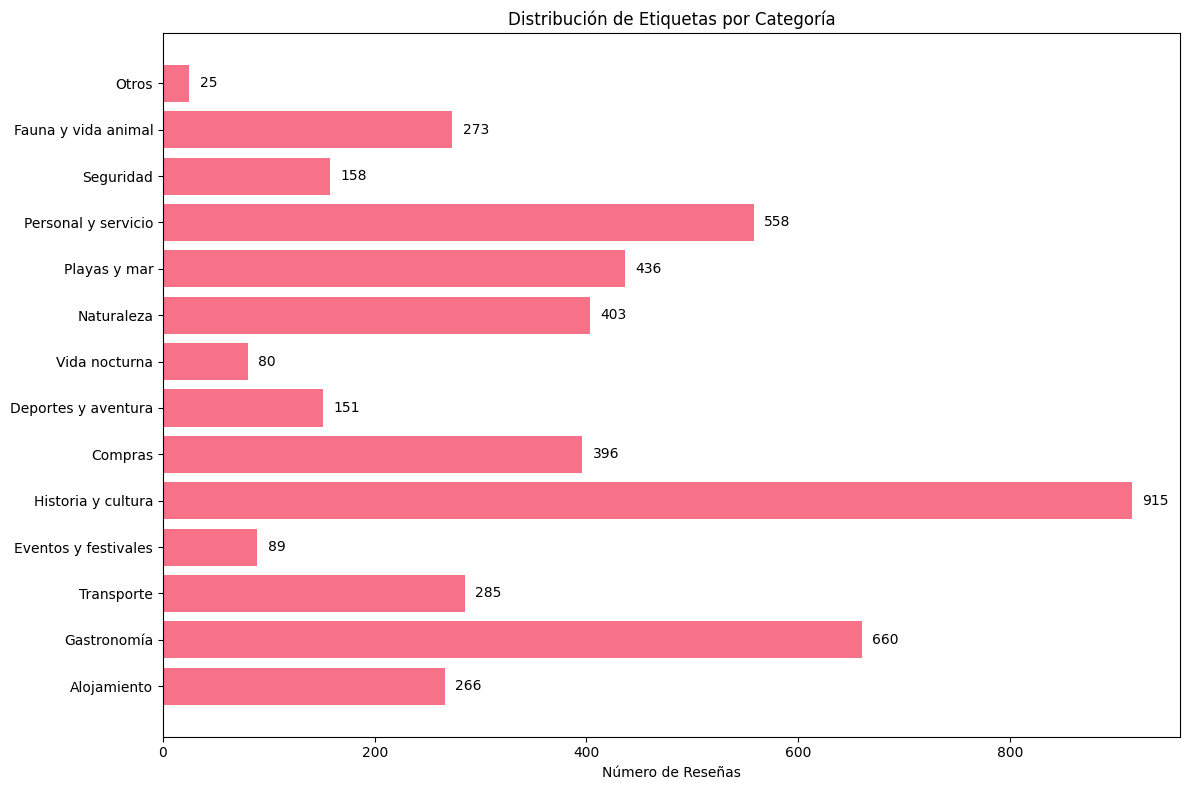

üìä DISTRIBUCI√ìN DE ETIQUETAS:
 4. Historia y cultura                   915 ( 37.2%)
 1. Gastronom√≠a                          660 ( 26.9%)
10. Personal y servicio                  558 ( 22.7%)
 9. Playas y mar                         436 ( 17.7%)
 8. Naturaleza                           403 ( 16.4%)
 5. Compras                              396 ( 16.1%)
 2. Transporte                           285 ( 11.6%)
12. Fauna y vida animal                  273 ( 11.1%)
 0. Alojamiento                          266 ( 10.8%)
11. Seguridad                            158 (  6.4%)
 6. Deportes y aventura                  151 (  6.1%)
 3. Eventos y festivales                  89 (  3.6%)
 7. Vida nocturna                         80 (  3.3%)
13. Otros                                 25 (  1.0%)

Total de etiquetas asignadas: 4695
Total de rese√±as: 2457
Promedio de etiquetas por rese√±a: 1.91


In [9]:
if 'labels_parsed' in df.columns:
    # Contar todas las etiquetas
    all_labels = []
    for labels_list in df['labels_parsed']:
        all_labels.extend(labels_list)
    
    label_counts = Counter(all_labels)
    
    # Crear DataFrame para visualizaci√≥n (ahora hasta categor√≠a 13)
    labels_df = pd.DataFrame([
        {'categoria_id': i, 'categoria_nombre': category_names[i], 'count': label_counts.get(i, 0)}
        for i in range(14)  # Cambiado de 13 a 14
    ])
    
    # Visualizaci√≥n 1: Gr√°fico de barras horizontal
    plt.figure(figsize=(12, 8))
    bars = plt.barh(labels_df['categoria_nombre'], labels_df['count'])
    plt.xlabel('N√∫mero de Rese√±as')
    plt.title('Distribuci√≥n de Etiquetas por Categor√≠a')
    plt.tight_layout()
    
    # A√±adir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        if width > 0:
            plt.text(width + 10, bar.get_y() + bar.get_height()/2, 
                    f'{int(width)}', ha='left', va='center')
    
    plt.show()
    
    # Mostrar estad√≠sticas detalladas
    print("üìä DISTRIBUCI√ìN DE ETIQUETAS:")
    print("=" * 60)
    for _, row in labels_df.sort_values('count', ascending=False).iterrows():
        porcentaje = (row['count'] / len(df)) * 100
        print(f"{row['categoria_id']:2d}. {row['categoria_nombre']:<35} {row['count']:4d} ({porcentaje:5.1f}%)")
    
    print(f"\nTotal de etiquetas asignadas: {sum(label_counts.values())}")
    print(f"Total de rese√±as: {len(df)}")
    print(f"Promedio de etiquetas por rese√±a: {sum(label_counts.values()) / len(df):.2f}")

## An√°lisis de Multi-Etiquetas

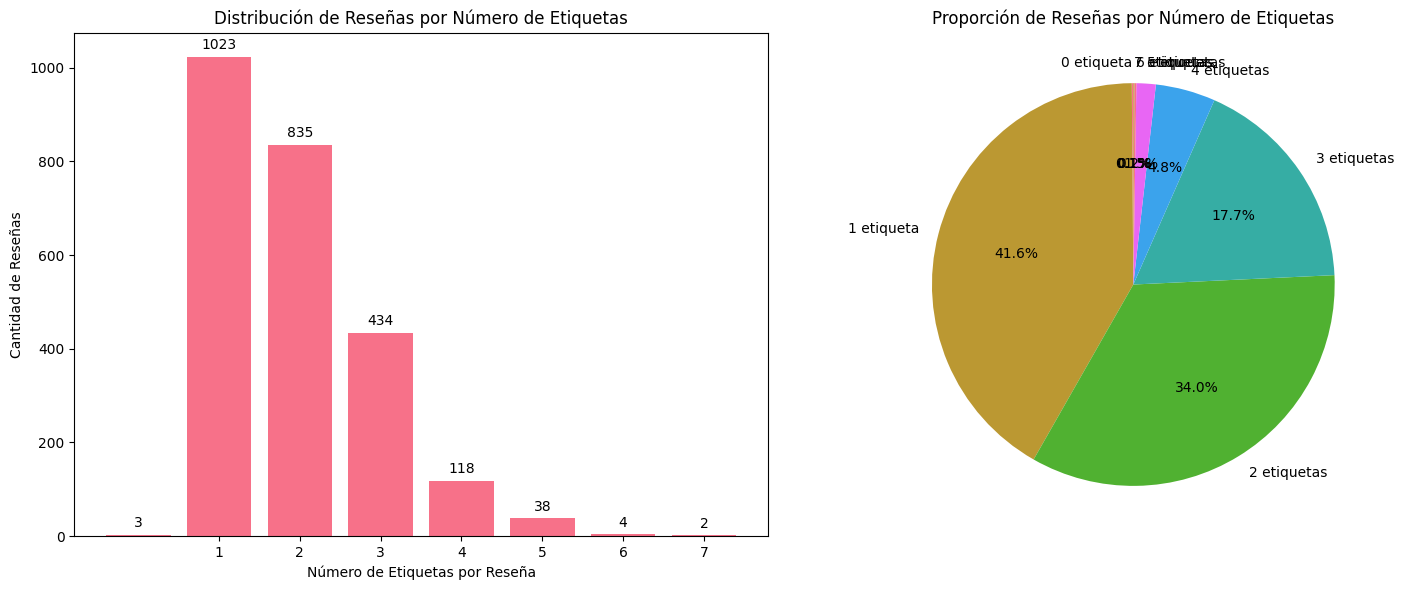

üìà AN√ÅLISIS DE MULTI-ETIQUETAS:
0 etiqueta:    3 rese√±as (  0.1%)
1 etiqueta: 1023 rese√±as ( 41.6%)
2 etiquetas:  835 rese√±as ( 34.0%)
3 etiquetas:  434 rese√±as ( 17.7%)
4 etiquetas:  118 rese√±as (  4.8%)
5 etiquetas:   38 rese√±as (  1.5%)
6 etiquetas:    4 rese√±as (  0.2%)
7 etiquetas:    2 rese√±as (  0.1%)

Rese√±as con m√∫ltiples etiquetas: 1431
Rese√±as con una sola etiqueta: 1023

üîÑ COMBINACIONES M√ÅS COMUNES (Top 10):
--------------------------------------------------
[1, 5] -> ['Gastronom√≠a', 'Compras'] (54 veces)
[1, 9] -> ['Gastronom√≠a', 'Playas y mar'] (52 veces)
[4, 10] -> ['Historia y cultura', 'Personal y servicio'] (43 veces)
[8, 9] -> ['Naturaleza', 'Playas y mar'] (43 veces)
[4, 5] -> ['Historia y cultura', 'Compras'] (41 veces)
[1, 4] -> ['Gastronom√≠a', 'Historia y cultura'] (41 veces)
[4, 8] -> ['Historia y cultura', 'Naturaleza'] (40 veces)
[10, 12] -> ['Personal y servicio', 'Fauna y vida animal'] (39 veces)
[2, 10] -> ['Transporte', 'Personal y ser

In [10]:
if 'labels_parsed' in df.columns:
    # An√°lisis de cantidad de etiquetas por rese√±a
    df['num_labels'] = df['labels_parsed'].apply(len)
    
    # Contar rese√±as por n√∫mero de etiquetas
    label_count_distribution = df['num_labels'].value_counts().sort_index()
    
    # Visualizaci√≥n: Distribuci√≥n de n√∫mero de etiquetas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gr√°fico de barras
    bars = ax1.bar(label_count_distribution.index, label_count_distribution.values)
    ax1.set_xlabel('N√∫mero de Etiquetas por Rese√±a')
    ax1.set_ylabel('Cantidad de Rese√±as')
    ax1.set_title('Distribuci√≥n de Rese√±as por N√∫mero de Etiquetas')
    ax1.set_xticks(range(1, max(label_count_distribution.index) + 1))
    
    # A√±adir valores en las barras
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{int(height)}', ha='center', va='bottom')
    
    # Gr√°fico de pie
    ax2.pie(label_count_distribution.values, labels=[f'{i} etiqueta{"s" if i>1 else ""}' for i in label_count_distribution.index],
            autopct='%1.1f%%', startangle=90)
    ax2.set_title('Proporci√≥n de Rese√±as por N√∫mero de Etiquetas')
    
    plt.tight_layout()
    plt.show()
    
    # Estad√≠sticas detalladas
    print("üìà AN√ÅLISIS DE MULTI-ETIQUETAS:")
    print("=" * 50)
    for num_labels, count in label_count_distribution.items():
        porcentaje = (count / len(df)) * 100
        print(f"{num_labels} etiqueta{'s' if num_labels > 1 else ''}: {count:4d} rese√±as ({porcentaje:5.1f}%)")
    
    print(f"\nRese√±as con m√∫ltiples etiquetas: {sum(label_count_distribution[label_count_distribution.index > 1])}")
    print(f"Rese√±as con una sola etiqueta: {label_count_distribution.get(1, 0)}")
    
    # Mostrar las combinaciones m√°s comunes de etiquetas m√∫ltiples
    multi_label_reviews = df[df['num_labels'] > 1]
    if len(multi_label_reviews) > 0:
        print(f"\nüîÑ COMBINACIONES M√ÅS COMUNES (Top 10):")
        print("-" * 50)
        combinations = multi_label_reviews['labels_parsed'].apply(tuple).value_counts().head(10)
        for combo, count in combinations.items():
            combo_names = [category_names[i] for i in combo]
            print(f"{list(combo)} -> {combo_names} ({count} veces)")

## Matriz de Co-ocurrencia de Etiquetas

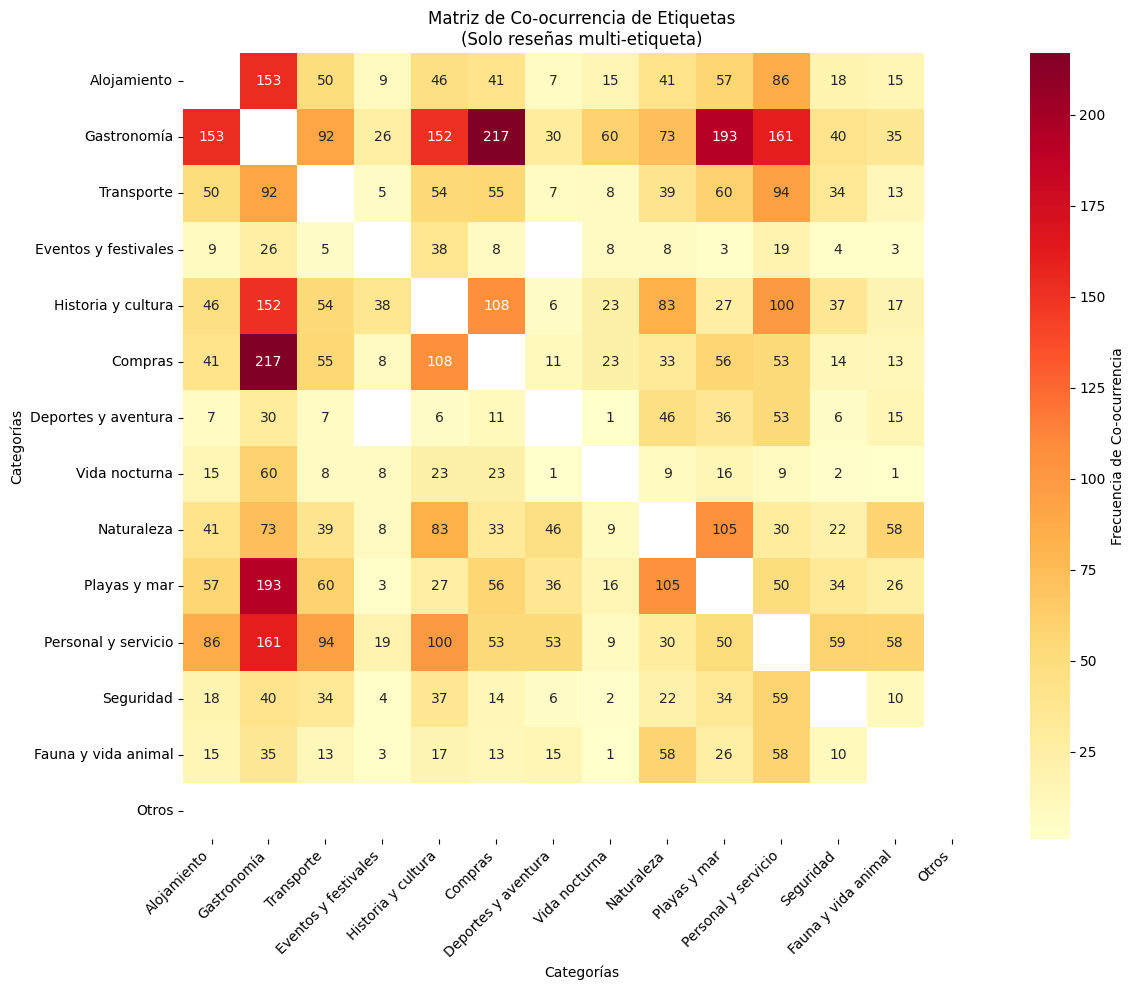

üîó CO-OCURRENCIAS M√ÅS FRECUENTES:
Gastronom√≠a ‚Üî Compras: 434 veces
Gastronom√≠a ‚Üî Playas y mar: 386 veces
Gastronom√≠a ‚Üî Personal y servicio: 322 veces
Alojamiento ‚Üî Gastronom√≠a: 306 veces
Gastronom√≠a ‚Üî Historia y cultura: 304 veces
Historia y cultura ‚Üî Compras: 216 veces
Naturaleza ‚Üî Playas y mar: 210 veces
Historia y cultura ‚Üî Personal y servicio: 200 veces
Transporte ‚Üî Personal y servicio: 188 veces
Gastronom√≠a ‚Üî Transporte: 184 veces


In [11]:
if 'labels_parsed' in df.columns:
    # Crear matriz de co-ocurrencia (ahora 14x14)
    cooccurrence_matrix = np.zeros((14, 14))
    
    for labels_list in df['labels_parsed']:
        if len(labels_list) > 1:  # Solo para rese√±as multi-etiqueta
            for i in labels_list:
                for j in labels_list:
                    if i != j and i < 14 and j < 14:  # Asegurar rango v√°lido
                        cooccurrence_matrix[i][j] += 1
    
    # Crear etiquetas abreviadas para la matriz
    short_names = [name[:20] + ('...' if len(name) > 20 else '') for name in category_names]
    
    # Visualizar matriz de co-ocurrencia
    plt.figure(figsize=(12, 10))
    mask = cooccurrence_matrix == 0  # Ocultar valores cero
    sns.heatmap(cooccurrence_matrix, 
                xticklabels=short_names,
                yticklabels=short_names,
                annot=True, 
                fmt='.0f',
                cmap='YlOrRd',
                mask=mask,
                cbar_kws={'label': 'Frecuencia de Co-ocurrencia'})
    
    plt.title('Matriz de Co-ocurrencia de Etiquetas\n(Solo rese√±as multi-etiqueta)')
    plt.xlabel('Categor√≠as')
    plt.ylabel('Categor√≠as')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Encontrar las co-ocurrencias m√°s frecuentes
    print("üîó CO-OCURRENCIAS M√ÅS FRECUENTES:")
    print("=" * 50)
    
    cooccurrences = []
    for i in range(14):  # Cambiado de 13 a 14
        for j in range(i+1, 14):  # Evitar duplicados
            if cooccurrence_matrix[i][j] + cooccurrence_matrix[j][i] > 0:
                total_cooccurrence = cooccurrence_matrix[i][j] + cooccurrence_matrix[j][i]
                cooccurrences.append((total_cooccurrence, i, j))
    
    cooccurrences.sort(reverse=True)
    
    for count, i, j in cooccurrences[:10]:  # Top 10
        print(f"{category_names[i]} ‚Üî {category_names[j]}: {int(count)} veces")

## Listado Completo de Rese√±as y sus Etiquetas

### Rese√±as Clasificadas como "Otros" [12]

In [15]:
if 'labels_parsed' in df.columns:
    # Funci√≥n para mapear etiquetas a nombres
    def labels_to_names(labels_list):
        return [category_names[label] for label in labels_list if label < len(category_names)]
    
    # Filtrar rese√±as con etiqueta [13] (Otros) - Cambiado de 12 a 13
    otros_reviews = df[df['labels_parsed'].apply(lambda x: x == [13])].copy()
    
    print("üè∑Ô∏è RESE√ëAS CLASIFICADAS COMO 'OTROS' [13]:")
    print("=" * 80)
    print(f"Total encontradas: {len(otros_reviews)}")
    print("-" * 80)
    
    if len(otros_reviews) > 0:
        for idx, (_, row) in enumerate(otros_reviews.iterrows(), 1):
            etiquetas_nombres = labels_to_names(row['labels_parsed'])
            print(f"{idx:3d}. Etiquetas: {row['labels_parsed']} -> {etiquetas_nombres}")
            print(f"     Rese√±a: {row['TituloReview']}")
            print("-" * 80)
    else:
        print("No se encontraron rese√±as clasificadas √∫nicamente como 'Otros'")
    
    # Estad√≠stica adicional sobre "Otros"
    total_with_otros = len(df[df['labels_parsed'].apply(lambda x: 13 in x)])  # Cambiado de 12 a 13
    print(f"\n‚ÑπÔ∏è  Rese√±as que incluyen etiqueta 13 (en cualquier combinaci√≥n): {total_with_otros}")
    print(f"‚ÑπÔ∏è  Rese√±as que SOLO tienen etiqueta 13: {len(otros_reviews)}")

üè∑Ô∏è RESE√ëAS CLASIFICADAS COMO 'OTROS' [13]:
Total encontradas: 25
--------------------------------------------------------------------------------
  1. Etiquetas: [13] -> ['Otros']
     Rese√±a: algo caro. esta muy padre pero siento que esta algo caro para lo que ofrece el recorrido de una hora y media....
--------------------------------------------------------------------------------
  2. Etiquetas: [13] -> ['Otros']
     Rese√±a: Estafar en im√°genes. Estafa completa en im√°genes. Mientras que la experiencia es agradable. Cotizan $ 250 - $ 294 para fotos. Si vas con una familia y como no puedes tomar tus propias fotos, saben que te tienen. No lo descontar√°n. As√≠ que t√©cnicamente usted 2 - 3 veces el precio del boleto de entrada.
--------------------------------------------------------------------------------
  3. Etiquetas: [13] -> ['Otros']
     Rese√±a: Aquadivertido. Experiencia bonita e informativa, hab√≠a tenido malos comentarios al respecto pero a√∫n as√≠ quise ir a ve

### Rese√±as con Discordancias entre Modelos LLM

In [16]:
if 'labels_parsed' in df.columns and len(llm_columns) > 1:
    print("üîç RESE√ëAS CON DISCORDANCIAS ENTRE MODELOS LLM:")
    print("=" * 120)
    print(f"Modelos disponibles: {llm_columns}")
    
    # Funci√≥n para parsear etiquetas de cualquier columna
    def parse_labels_from_column(value):
        if isinstance(value, str):
            try:
                return ast.literal_eval(value)
            except:
                return [13]
        elif isinstance(value, list):
            return value
        else:
            return [13]
    
    # Encontrar rese√±as con discordancias
    discordant_reviews = []
    
    for idx, row in df.iterrows():
        if len(llm_columns) >= 2:
            # Parsear etiquetas de todos los modelos disponibles
            model_labels = {}
            for col in llm_columns:
                try:
                    # Verificar si la columna existe y tiene un valor v√°lido
                    if col in df.columns and row[col] is not None and str(row[col]).strip() != '' and str(row[col]) != 'nan':
                        model_labels[col] = set(parse_labels_from_column(row[col]))
                except Exception as e:
                    # Si hay alg√∫n error, usar etiqueta por defecto
                    model_labels[col] = set([13])
            
            # Verificar si hay discordancias comparando todos los pares
            has_discordance = False
            if len(model_labels) >= 2:
                label_sets = list(model_labels.values())
                # Comparar todos los conjuntos de etiquetas
                for i in range(len(label_sets)):
                    for j in range(i + 1, len(label_sets)):
                        if label_sets[i] != label_sets[j]:
                            has_discordance = True
                            break
                    if has_discordance:
                        break
            
            if has_discordance:
                discordant_reviews.append((idx, row, model_labels))
    
    print(f"üìä Total de discordancias encontradas: {len(discordant_reviews)}/{len(df)} ({len(discordant_reviews)/len(df)*100:.1f}%)")
    print("-" * 120)
    
    if len(discordant_reviews) > 0:
        for idx, (orig_idx, row, model_labels) in enumerate(discordant_reviews, 1):
            print(f"{idx:4d}. Rese√±a: {row['TituloReview']}")
            
            # Mostrar etiquetas de todos los modelos con discordancias
            for col, labels_set in model_labels.items():
                labels_list = sorted(list(labels_set))
                etiquetas_nombres = [category_names[label] for label in labels_list if label < len(category_names)]
                etiquetas_str = ', '.join(etiquetas_nombres)
                
                # Extraer nombre del modelo de la columna
                model_name = col.replace('TopicoConLLM_', '') if col.startswith('TopicoConLLM_') else col
                
                print(f"      {model_name:>15}: {labels_list} -> [{etiquetas_str}]")
            
            print("-" * 120)
            
            # Pausa cada 20 rese√±as para evitar output muy largo
            if idx % 20 == 0:
                print(f"\n... Mostrando {idx} de {len(discordant_reviews)} discordancias ...")
                print("Contin√∫a para ver todas...\n")
        
        print(f"\n‚úÖ An√°lisis de discordancias completado. Total mostrado: {len(discordant_reviews)} rese√±as con discordancias")
    else:
        print("‚úÖ No se encontraron discordancias entre los modelos (todos coinciden perfectamente)")

elif len(llm_columns) <= 1:
    print("‚ÑπÔ∏è Se necesitan al menos 2 modelos LLM para detectar discordancias.")
    print(f"Modelos disponibles: {llm_columns}")
else:
    print("‚ùå No se encontraron etiquetas parseadas. Ejecuta primero la secci√≥n de an√°lisis.")

üîç RESE√ëAS CON DISCORDANCIAS ENTRE MODELOS LLM:
Modelos disponibles: ['TopicoConLLM', 'TopicoConLLM_gpt-4o-mini', 'TopicoConLLM_gpt-4.1-mini']
üìä Total de discordancias encontradas: 1697/2457 (69.1%)
------------------------------------------------------------------------------------------------------------------------
   1. Rese√±a: ¬°Divertido y seguro!. Estoy muy impresionado con Mazatl√°n, Mx. . La gente aqu√≠ es amable. . nos alojamos en El Cid resort el Moro. . Me encant√≥ el complejo, las piscinas eran divertidas y el personal de los restaurantes nos cuid√≥ mucho. . . Mis hijos tambi√©n se alojaron en el club infantil, Leti y Susan cuidaron mucho de mis dos hijos mientras disfrutaba de mi tiempo en la piscina. Tambi√©n dimos un paseo hasta el Malec√≥n, NO hay problemas durante mi paseo, la vibra era divertida y segura . . . todos conduciendo y caminando nos lo estamos pasando genial . . . Gracias Mazatl√°n este es ahora mi nuevo lugar de vacaciones. . . Volver√© en mis pr√≥

## Resumen Final del An√°lisis de Etiquetas

In [17]:
if 'labels_parsed' in df.columns:
    print("üìä RESUMEN EJECUTIVO DEL ETIQUETADO")
    print("=" * 60)
    
    # M√©tricas generales
    total_reviews = len(df)
    total_labels_assigned = sum(len(labels) for labels in df['labels_parsed'])
    avg_labels_per_review = total_labels_assigned / total_reviews
    
    # Distribuci√≥n por n√∫mero de etiquetas
    single_label = len(df[df['num_labels'] == 1])
    multi_label = len(df[df['num_labels'] > 1])
    max_labels = df['num_labels'].max()
    
    # Categor√≠a m√°s y menos asignada
    label_counts = Counter()
    for labels in df['labels_parsed']:
        for label in labels:
            label_counts[label] += 1
    
    most_common_label = label_counts.most_common(1)[0]
    least_common_labels = [label for label, count in label_counts.items() if count == min(label_counts.values())]
    
    # Casos especiales (cambiado de 12 a 13)
    otros_only = len(df[df['labels_parsed'].apply(lambda x: x == [13])])
    has_otros = len(df[df['labels_parsed'].apply(lambda x: 13 in x)])
    
    print(f"üìà ESTAD√çSTICAS GENERALES:")
    print(f"   ‚Ä¢ Total de rese√±as procesadas: {total_reviews:,}")
    print(f"   ‚Ä¢ Total de etiquetas asignadas: {total_labels_assigned:,}")
    print(f"   ‚Ä¢ Promedio de etiquetas por rese√±a: {avg_labels_per_review:.2f}")
    print(f"   ‚Ä¢ M√°ximo de etiquetas en una rese√±a: {max_labels}")
    
    print(f"\nüè∑Ô∏è  DISTRIBUCI√ìN DE ETIQUETADO:")
    print(f"   ‚Ä¢ Rese√±as con una sola etiqueta: {single_label:,} ({single_label/total_reviews*100:.1f}%)")
    print(f"   ‚Ä¢ Rese√±as multi-etiqueta: {multi_label:,} ({multi_label/total_reviews*100:.1f}%)")
    
    print(f"\nüéØ CATEGOR√çAS M√ÅS RELEVANTES:")
    print(f"   ‚Ä¢ M√°s asignada: {category_names[most_common_label[0]]} ({most_common_label[1]:,} veces)")
    
    if least_common_labels:
        least_names = [category_names[label] for label in least_common_labels]
        print(f"   ‚Ä¢ Menos asignada(s): {', '.join(least_names)} ({min(label_counts.values())} veces)")
    
    print(f"\n‚ö†Ô∏è  CASOS ESPECIALES:")
    print(f"   ‚Ä¢ Rese√±as clasificadas solo como 'Otros': {otros_only}")
    print(f"   ‚Ä¢ Rese√±as que incluyen 'Otros': {has_otros}")
    
    # Calidad del etiquetado
    quality_score = (1 - (otros_only / total_reviews)) * 100
    print(f"\n‚úÖ INDICADOR DE CALIDAD DEL ETIQUETADO: {quality_score:.1f}%")
    print(f"   (Basado en rese√±as NO clasificadas √∫nicamente como 'Otros')")
    
    # Recomendaciones
    print(f"\nüí° OBSERVACIONES:")
    if otros_only / total_reviews > 0.05:  # Si m√°s del 5% son "Otros"
        print(f"   ‚ö†Ô∏è  Alto porcentaje de rese√±as 'Otros' ({otros_only/total_reviews*100:.1f}%)")
        print(f"      Considera revisar estas rese√±as para posibles mejoras en el prompt")
    
    if avg_labels_per_review > 2:
        print(f"   ‚ÑπÔ∏è  Promedio alto de etiquetas por rese√±a ({avg_labels_per_review:.2f})")
        print(f"      El modelo tiende a ser inclusivo en la clasificaci√≥n")
    
    if multi_label / total_reviews > 0.3:
        print(f"   ‚úÖ Buen uso de clasificaci√≥n multi-etiqueta ({multi_label/total_reviews*100:.1f}%)")
    
    print("\n" + "=" * 60)

üìä RESUMEN EJECUTIVO DEL ETIQUETADO
üìà ESTAD√çSTICAS GENERALES:
   ‚Ä¢ Total de rese√±as procesadas: 2,457
   ‚Ä¢ Total de etiquetas asignadas: 4,695
   ‚Ä¢ Promedio de etiquetas por rese√±a: 1.91
   ‚Ä¢ M√°ximo de etiquetas en una rese√±a: 7

üè∑Ô∏è  DISTRIBUCI√ìN DE ETIQUETADO:
   ‚Ä¢ Rese√±as con una sola etiqueta: 1,023 (41.6%)
   ‚Ä¢ Rese√±as multi-etiqueta: 1,431 (58.2%)

üéØ CATEGOR√çAS M√ÅS RELEVANTES:
   ‚Ä¢ M√°s asignada: Historia y cultura (915 veces)
   ‚Ä¢ Menos asignada(s): Otros (25 veces)

‚ö†Ô∏è  CASOS ESPECIALES:
   ‚Ä¢ Rese√±as clasificadas solo como 'Otros': 25
   ‚Ä¢ Rese√±as que incluyen 'Otros': 25

‚úÖ INDICADOR DE CALIDAD DEL ETIQUETADO: 99.0%
   (Basado en rese√±as NO clasificadas √∫nicamente como 'Otros')

üí° OBSERVACIONES:
   ‚úÖ Buen uso de clasificaci√≥n multi-etiqueta (58.2%)



## Comparaci√≥n entre Modelos LLM

Esta secci√≥n compara los resultados de etiquetado entre diferentes modelos LLM para identificar diferencias en la clasificaci√≥n.

In [18]:
if len(llm_columns) > 1:
    print("üîÑ COMPARACI√ìN ENTRE MODELOS:")
    print("=" * 80)
    
    # Estad√≠sticas por modelo
    for col in llm_columns:
        if col in df.columns:
            model_name = col.replace('TopicoConLLM_', '') if col.startswith('TopicoConLLM_') else col
            
            # Parsear etiquetas de este modelo
            def parse_model_labels(label_value):
                if isinstance(label_value, str):
                    try:
                        return ast.literal_eval(label_value)
                    except:
                        return [13]
                elif isinstance(label_value, list):
                    return label_value
                else:
                    return [13]
            
            df[f'{col}_parsed'] = df[col].apply(parse_model_labels)
            
            # Calcular estad√≠sticas
            total_labels = sum(len(labels) for labels in df[f'{col}_parsed'])
            avg_labels = total_labels / len(df)
            multi_label_pct = (sum(1 for labels in df[f'{col}_parsed'] if len(labels) > 1) / len(df)) * 100
            otros_only_count = sum(1 for labels in df[f'{col}_parsed'] if labels == [13])
            
            print(f"\nüìä MODELO: {model_name}")
            print(f"   ‚Ä¢ Promedio de etiquetas por rese√±a: {avg_labels:.2f}")
            print(f"   ‚Ä¢ Rese√±as multi-etiqueta: {multi_label_pct:.1f}%")
            print(f"   ‚Ä¢ Rese√±as solo 'Otros': {otros_only_count} ({otros_only_count/len(df)*100:.1f}%)")
    
    # Comparar diferencias entre el primer y √∫ltimo modelo
    if len(llm_columns) >= 2:
        col1, col2 = llm_columns[0], llm_columns[-1]
        model1 = col1.replace('TopicoConLLM_', '') if col1.startswith('TopicoConLLM_') else col1
        model2 = col2.replace('TopicoConLLM_', '') if col2.startswith('TopicoConLLM_') else col2
        
        print(f"\nüîç DIFERENCIAS ENTRE {model1} vs {model2}:")
        print("-" * 60)
        
        differences_count = 0
        for idx, row in df.iterrows():
            # Parsear etiquetas de ambos modelos
            try:
                labels1 = ast.literal_eval(row[col1]) if isinstance(row[col1], str) else (row[col1] if isinstance(row[col1], list) else [13])
                labels2 = ast.literal_eval(row[col2]) if isinstance(row[col2], str) else (row[col2] if isinstance(row[col2], list) else [13])
            except:
                labels1, labels2 = [13], [13]
            
            if set(labels1) != set(labels2):
                differences_count += 1
                if differences_count <= 10:  # Mostrar solo los primeros 10
                    names1 = [category_names[l] for l in labels1 if l < len(category_names)]
                    names2 = [category_names[l] for l in labels2 if l < len(category_names)]
                    print(f"{differences_count:2d}. {row['TituloReview'][:50]}...")
                    print(f"    {model1}: {labels1} -> {names1}")
                    print(f"    {model2}: {labels2} -> {names2}")
                    print()
        
        print(f"Total de rese√±as con diferencias: {differences_count}/{len(df)} ({differences_count/len(df)*100:.1f}%)")

else:
    print("‚ÑπÔ∏è Solo hay un modelo disponible. Ejecuta el etiquetado con diferentes modelos para comparar.")

üîÑ COMPARACI√ìN ENTRE MODELOS:

üìä MODELO: TopicoConLLM
   ‚Ä¢ Promedio de etiquetas por rese√±a: 1.85
   ‚Ä¢ Rese√±as multi-etiqueta: 55.1%
   ‚Ä¢ Rese√±as solo 'Otros': 22 (0.9%)

üìä MODELO: gpt-4o-mini
   ‚Ä¢ Promedio de etiquetas por rese√±a: 1.91
   ‚Ä¢ Rese√±as multi-etiqueta: 58.2%
   ‚Ä¢ Rese√±as solo 'Otros': 25 (1.0%)

üìä MODELO: gpt-4.1-mini
   ‚Ä¢ Promedio de etiquetas por rese√±a: 2.28
   ‚Ä¢ Rese√±as multi-etiqueta: 72.8%
   ‚Ä¢ Rese√±as solo 'Otros': 10 (0.4%)

üîç DIFERENCIAS ENTRE TopicoConLLM vs gpt-4.1-mini:
------------------------------------------------------------
 1. ¬°Divertido y seguro!. Estoy muy impresionado con M...
    TopicoConLLM: [0, 1, 8, 10] -> ['Alojamiento', 'Gastronom√≠a', 'Naturaleza', 'Personal y servicio']
    gpt-4.1-mini: [0, 1, 10, 11] -> ['Alojamiento', 'Gastronom√≠a', 'Personal y servicio', 'Seguridad']

 2. Un mes en Mazatl√°n. Acabamos de pasar un mes en Ma...
    TopicoConLLM: [11, 13] -> ['Seguridad', 'Otros']
    gpt-4.1-mini: